# Introducción, objetivos y contenido
========================================================================================================================================

El presente trabajo corresponde a la unidad nro 14 del curso de Data Analytics de TripleTen, denominada "Proyecto Final". El trabajo analizar un servicio de telofonía virtual ("Call Me Maybe") para conocer la eficacia de los operadores. 

Contenidos / Plan de Trabajo:

* Importación de librerías y carga de datos
* Preprocesamiento de datos
    * Verificación de tipo de datos
    * Verificación de duplicados
    * Verificación de nulos
* Análisis de datos (EDA)
    * Valores medios de grupos (clientes activos y cancelados)
    * Distribuciones de grupos
    * Matriz de correlación
* Identificación de ineficacias
    * Cantidad de llamadas entrantes perdidas (internas y externas)
    * Tiempos de espera prolongados para llamadas entrantes
    * Cantidad deficiente de llamadas salientes
* Pruebas de hipótesis
* Conclusiones

# Importación de librerías y carga de datos
========================================================================================================================================

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, time, date



In [2]:
dfc = pd.read_csv('telecom_clients_us.csv', delimiter = ",")
dfo = pd.read_csv('telecom_dataset_us.csv', delimiter = ",") # registro de operaciones

# Preprocesamiento de datos
========================================================================================================================================

## Dataset CLIENTS

In [3]:
dfc.info()
dfc.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
230,167575,C,2019-09-20
425,168077,C,2019-10-11


In [4]:
# Corrección de tipos de dato
dfc['date_start'] = pd.to_datetime(dfc['date_start'])

dfc.info()
dfc.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
600,167338,B,2019-09-12


In [5]:
# Verificación de duplicados
dfc.duplicated().sum()

0

In [6]:
# Verificación de nulos
dfc.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

## Dataset OPERACIONES

In [7]:
print(dfo.info())
dfo.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8810,166658,2019-10-01 00:00:00+03:00,out,False,890404.0,True,9,0,167
3358,166485,2019-10-30 00:00:00+03:00,in,False,NaN,True,2,0,61


In [8]:
# Corrección de tipos de dato y agregado de campos

dfo['waiting_time'] = dfo['total_call_duration'] - dfo['call_duration']
dfo['call_duration_unit'] = (dfo['call_duration']/dfo['calls_count']).round(1)
dfo['total_call_duration_unit'] = (dfo['total_call_duration']/dfo['calls_count']).round(1)
dfo['waiting_time_unit'] = (dfo['waiting_time']/dfo['calls_count']).round(1)

dfo['date'] = pd.to_datetime(dfo['date'])
dfo['ymd'] = dfo['date'].dt.strftime('%Y-%m-%d')
dfo['year'] = dfo['date'].dt.year
dfo['month'] = dfo['date'].dt.month
dfo['day'] = dfo['date'].dt.day
dfo['weeknumber'] = dfo['date'].dt.isocalendar().week
dfo['weekday'] = dfo['date'].dt.weekday
dfo['hour'] = dfo['date'].dt.hour
dfo['minute'] = dfo['date'].dt.minute

dfo['internal'] = dfo['internal'].astype(bool)
dfo['is_missed_call'] = dfo['is_missed_call'].astype(bool)

dfo['direction_in'] = dfo['direction'].apply(lambda x: 1 if x == 'in' else 0)
dfo['direction_out'] = dfo['direction'].apply(lambda x: 1 if x == 'out' else 0)
dfo['scope_int'] = dfo['internal'].astype(int)
dfo['scope_ext'] = (~dfo['internal']).astype(int)
dfo['result_missed'] = dfo['is_missed_call'].astype(int)
dfo['result_notmissed'] = (~dfo['is_missed_call']).astype(int)
dfo['in_missed'] = (dfo.apply(lambda row: 1 if row['direction_in'] and row['result_missed'] == 1 else 0, axis=1))*dfo['calls_count']


dfo['direction_in_tot'] = dfo['direction_in']*dfo['calls_count']
dfo['direction_out_tot'] = dfo['direction_out']*dfo['calls_count']
dfo['scope_int_tot'] = dfo['scope_int']*dfo['calls_count']
dfo['scope_ext_tot'] = dfo['scope_ext']*dfo['calls_count']
dfo['result_missed_tot'] = dfo['result_missed']*dfo['calls_count']
dfo['result_notmissed_tot'] = dfo['result_notmissed']*dfo['calls_count']
dfo['in_missed_tot'] = (dfo.apply(lambda row: 1 if row['direction_in'] and row['result_missed'] == 1 else 0, axis=1))*dfo['calls_count']

dfo.info()
dfo.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype                    
---  ------                    --------------  -----                    
 0   user_id                   53902 non-null  int64                    
 1   date                      53902 non-null  datetime64[ns, UTC+03:00]
 2   direction                 53902 non-null  object                   
 3   internal                  53902 non-null  bool                     
 4   operator_id               45730 non-null  float64                  
 5   is_missed_call            53902 non-null  bool                     
 6   calls_count               53902 non-null  int64                    
 7   call_duration             53902 non-null  int64                    
 8   total_call_duration       53902 non-null  int64                    
 9   waiting_time              53902 non-null  int64                    
 10  call_durat

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,...,result_missed,result_notmissed,in_missed,direction_in_tot,direction_out_tot,scope_int_tot,scope_ext_tot,result_missed_tot,result_notmissed_tot,in_missed_tot
13569,166800,2019-08-27 00:00:00+03:00,in,False,NaN,True,6,0,149,149,...,1,0,6,6,0,0,6,6,0,6
41187,167828,2019-11-22 00:00:00+03:00,in,False,940442.0,False,7,692,695,3,...,0,1,0,7,0,0,7,0,7,0


In [9]:
# Verificación de duplicados
dfo.duplicated().sum()

4900

In [10]:
# Eliminación de duplicados
dfo = dfo.drop_duplicates()
dfo.duplicated().sum()

0

In [11]:
# Verificación de nulos
dfo.isna().sum()

user_id                        0
date                           0
direction                      0
internal                       0
operator_id                 7456
is_missed_call                 0
calls_count                    0
call_duration                  0
total_call_duration            0
waiting_time                   0
call_duration_unit             0
total_call_duration_unit       0
waiting_time_unit              0
ymd                            0
year                           0
month                          0
day                            0
weeknumber                     0
weekday                        0
hour                           0
minute                         0
direction_in                   0
direction_out                  0
scope_int                      0
scope_ext                      0
result_missed                  0
result_notmissed               0
in_missed                      0
direction_in_tot               0
direction_out_tot              0
scope_int_

In [12]:
dfo_nulls = dfo[dfo['operator_id'].isna()]
dfo_nulls.sample(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,...,result_missed,result_notmissed,in_missed,direction_in_tot,direction_out_tot,scope_int_tot,scope_ext_tot,result_missed_tot,result_notmissed_tot,in_missed_tot
53668,168481,2019-11-12 00:00:00+03:00,in,False,NaN,True,7,0,141,141,...,1,0,7,7,0,0,7,7,0,7
31229,167412,2019-11-16 00:00:00+03:00,in,True,NaN,True,1,0,2,2,...,1,0,1,1,0,1,0,1,0,1


In [13]:
dfo_nulls['call_duration'].sum()

497685

In [14]:
# Análisis de valores nulos del campo "operator_id"
# Buscaremos algún patrón para ver si es posible conocer los valores nulos del campo operator_id

print(f'Características del dataset con valores nulos en el campo "operator_id: ')
print('------------------------------------------------------------------------')
print(f'Cantidad de operadores únicos: {dfo_nulls['operator_id'].nunique()}')
print(f'Cantidad de usuarios únicos: {dfo_nulls['user_id'].nunique()}')
print(f'Cantidad de fechas únicas: {dfo_nulls['date'].nunique()}')
print(f'Lista de semanas: {dfo_nulls['weeknumber'].unique()}')
print(f'Lista de meses: {dfo_nulls['month'].unique()}')
print(f'Lista de días del mes: {dfo_nulls['day'].unique()}')
print(f'Lista de días de la semana: {dfo_nulls['weekday'].unique()}')
print(f'Suma de duraciones: {dfo_nulls['call_duration'].sum()}')

Características del dataset con valores nulos en el campo "operator_id: 
------------------------------------------------------------------------
Cantidad de operadores únicos: 0
Cantidad de usuarios únicos: 305
Cantidad de fechas únicas: 119
Lista de semanas: <IntegerArray>
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 46, 47]
Length: 18, dtype: UInt32
Lista de meses: [ 8  9 10 11]
Lista de días del mes: [ 4  5  6  7 12 13 14 22 23 24 29  3  9 10 11 16 17  2  8 15 19 20 28 26
 18 27  1 21 30 25 31]
Lista de días de la semana: [6 0 1 2 3 4 5]
Suma de duraciones: 497685


In [15]:
dfo_nulls.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,waiting_time,call_duration_unit,total_call_duration_unit,waiting_time_unit,year,...,result_missed,result_notmissed,in_missed,direction_in_tot,direction_out_tot,scope_int_tot,scope_ext_tot,result_missed_tot,result_notmissed_tot,in_missed_tot
count,7456.000000,0.0,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.0,...,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000
mean,167259.123793,NaN,14.024142,66.749598,236.959496,170.209898,5.972116,24.401073,18.428930,2019.0,...,0.984844,0.015156,13.867623,13.954265,0.069877,0.154909,13.869233,13.894716,0.129426,13.867623
std,586.842979,NaN,81.785240,945.349645,1265.307052,842.134635,58.789568,61.832839,21.605769,0.0,...,0.122180,0.122180,81.791869,81.792459,0.877209,1.351755,81.800341,81.787627,1.790732,81.791869
min,166377.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,166782.000000,NaN,1.000000,0.000000,7.000000,7.000000,0.000000,3.000000,2.900000,2019.0,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
50%,167125.000000,NaN,2.000000,0.000000,35.000000,34.000000,0.000000,14.000000,13.800000,2019.0,...,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000
75%,167727.000000,NaN,7.000000,0.000000,115.000000,110.000000,0.000000,28.000000,27.000000,2019.0,...,1.000000,0.000000,6.000000,7.000000,0.000000,0.000000,6.000000,6.000000,0.000000,6.000000
max,168606.000000,NaN,2168.000000,26175.000000,42667.000000,42667.000000,1226.000000,1241.300000,465.000000,2019.0,...,1.000000,1.000000,2168.000000,2168.000000,34.000000,59.000000,2168.000000,2168.000000,52.000000,2168.000000


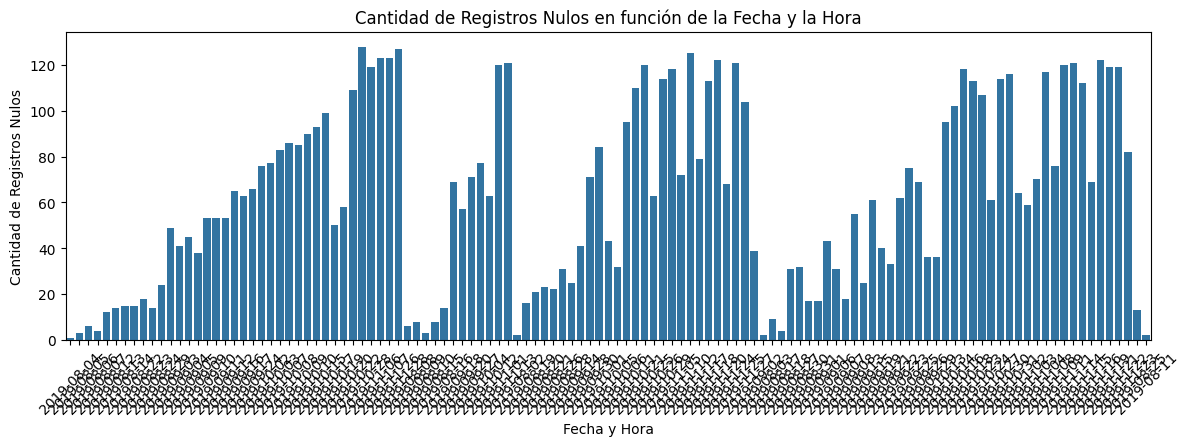

In [16]:
plt.figure(figsize=(14, 4))
sns.countplot(data=dfo_nulls, x='ymd')

plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad de Registros Nulos")
plt.title("Cantidad de Registros Nulos en función de la Fecha y la Hora")

plt.xticks(rotation=45)
plt.show()

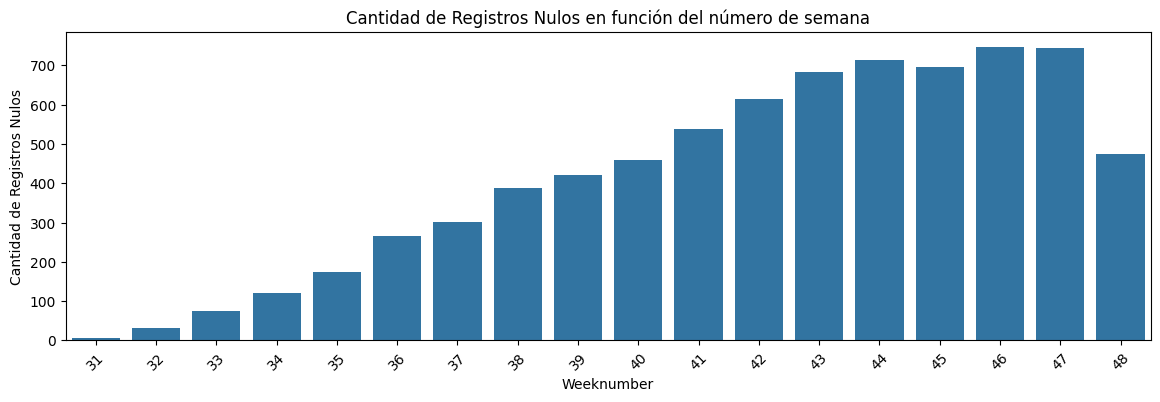

In [17]:
plt.figure(figsize=(14, 4))
sns.countplot(data=dfo_nulls, x='weeknumber')

plt.xlabel("Weeknumber")
plt.ylabel("Cantidad de Registros Nulos")
plt.title("Cantidad de Registros Nulos en función del número de semana")

plt.xticks(rotation=45)
plt.show()

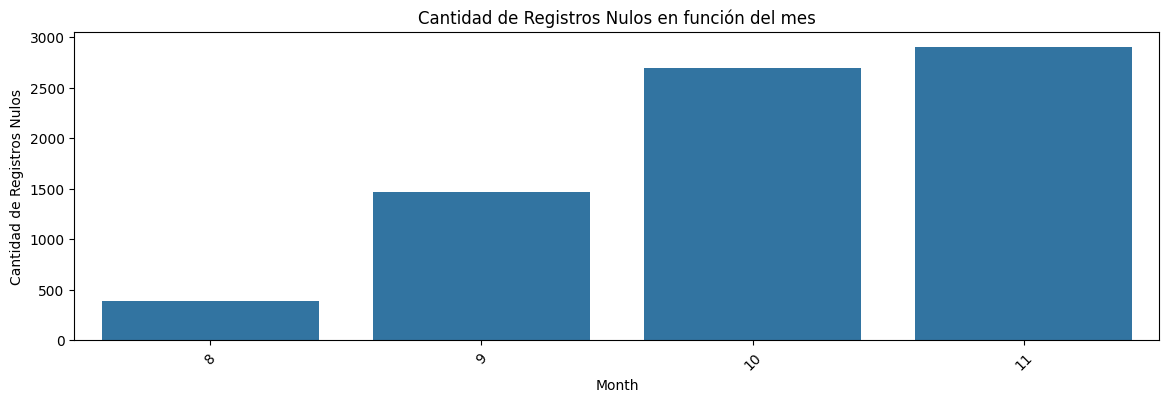

In [18]:
plt.figure(figsize=(14, 4))
sns.countplot(data=dfo_nulls, x='month')

plt.xlabel("Month")
plt.ylabel("Cantidad de Registros Nulos")
plt.title("Cantidad de Registros Nulos en función del mes")

plt.xticks(rotation=45)
plt.show()

* Se observan un total de 7456 registros con valores nulos en el campo "operator_id"
* Hay un total de 1092 operadores que registran trabajos a lo largo de 4 meses
* Se observa que los registros con valores nulos en el campo "operator_id" tiende a aumentar a lo largo de los 4 meses en que se muestra la data.

En función de posiblemente recuperar este valor para aportar información en la búsqueda de ineficiencias, he intentado buscar patrones en los registros para ver si a través de las fechas o los horarios de trabajo, se logra identificar aquellos operadores que no han sido registrados.

* No se logra establecer un patrón para recuperar los valores nulos, habiendo observado:
    * días de semana
    * días del mes
    * semanas
    * meses
    * horario: el dataset no posee este registro, lo cual dificulta la búsqueda de posibles patrones

Debido a ello, se decide eliminar estos valores nulos.

In [19]:
dfo = dfo.dropna(subset=['operator_id'])

dfo.isna().sum()

user_id                     0
date                        0
direction                   0
internal                    0
operator_id                 0
is_missed_call              0
calls_count                 0
call_duration               0
total_call_duration         0
waiting_time                0
call_duration_unit          0
total_call_duration_unit    0
waiting_time_unit           0
ymd                         0
year                        0
month                       0
day                         0
weeknumber                  0
weekday                     0
hour                        0
minute                      0
direction_in                0
direction_out               0
scope_int                   0
scope_ext                   0
result_missed               0
result_notmissed            0
in_missed                   0
direction_in_tot            0
direction_out_tot           0
scope_int_tot               0
scope_ext_tot               0
result_missed_tot           0
result_not

# Análisis de datos (EDA)
===================================================================================================================================

## Carga de trabajo - CALL CENTER

In [20]:
# Carga de trabajo mensual
workload_month = dfo.groupby(['month']).agg({'calls_count': 'sum', 'result_missed_tot':'sum', 'waiting_time':'sum', 'direction_in_tot':'sum', 'direction_out_tot':'sum', 'in_missed_tot':'sum'}).reset_index()
workload_month['missed_perc'] =  workload_month['result_missed_tot'] / workload_month['calls_count']
workload_month['waiting_time_avg'] =  workload_month['waiting_time'] / workload_month['calls_count']
workload_month

,month,calls_count,result_missed_tot,waiting_time,direction_in_tot,direction_out_tot,in_missed_tot,missed_perc,waiting_time_avg
0,8,34657,13092,719992,1681,32976,24,0.377759,20.774793
1,9,133803,51598,2730361,10891,122912,121,0.385627,20.405828
2,10,271096,108076,5047289,33282,237814,342,0.398663,18.618087
3,11,262589,99553,4457383,47948,214641,439,0.379121,16.974751


In [21]:
# Carga de trabajo semanal
workload_week = dfo.groupby(['weeknumber']).agg({'calls_count': 'sum', 'result_missed_tot':'sum', 'waiting_time':'mean', 'direction_in_tot':'sum', 'direction_out_tot':'sum', 'in_missed_tot':'sum'}).reset_index()
workload_week['missed_perc'] =  workload_week['result_missed_tot'] / workload_week['calls_count']
workload_week['waiting_time_avg'] =  workload_week['waiting_time'] / workload_week['calls_count']
workload_week

,weeknumber,calls_count,result_missed_tot,waiting_time,direction_in_tot,direction_out_tot,in_missed_tot,missed_perc,waiting_time_avg
0,31,50,24,54.733333,1,49,0,0.480000,1.094667
1,32,1252,353,149.789474,39,1213,0,0.281949,0.119640
2,33,7557,3008,778.424528,181,7376,3,0.398042,0.103007
3,34,11253,4357,551.120370,582,10671,11,0.387186,0.048975
4,35,15040,5533,414.133775,912,14128,10,0.367886,0.027535
5,36,21983,8148,408.423835,1555,20428,26,0.370650,0.018579
6,37,26227,9808,353.689404,1981,24246,34,0.373966,0.013486
7,38,27563,10350,339.509492,2234,25329,18,0.375503,0.012318
8,39,48539,19731,454.678506,4091,44448,34,0.406498,0.009367
9,40,61129,25091,475.740755,6141,54988,58,0.410460,0.007783


In [22]:
# Carga de trabajo diaria
workload_day = dfo.groupby(['ymd']).agg({'calls_count': 'sum', 'result_missed_tot':'sum', 'waiting_time':'mean', 'direction_in_tot':'sum', 'direction_out_tot':'sum', 'in_missed_tot':'sum'}).reset_index()
workload_day['missed_perc'] =  workload_day['result_missed_tot'] / workload_day['calls_count']
workload_day['waiting_time_avg'] =  workload_day['waiting_time'] / workload_day['calls_count']
workload_day

,ymd,calls_count,result_missed_tot,waiting_time,direction_in_tot,direction_out_tot,in_missed_tot,missed_perc,waiting_time_avg
0,2019-08-02,19,13,54.000000,0,19,0,0.684211,2.842105
1,2019-08-03,27,8,77.000000,1,26,0,0.296296,2.851852
2,2019-08-04,4,3,11.666667,0,4,0,0.750000,2.916667
3,2019-08-05,183,47,149.538462,3,180,0,0.256831,0.817150
4,2019-08-06,184,49,121.200000,7,177,0,0.266304,0.658696
...,...,...,...,...,...,...,...,...,...
113,2019-11-24,3333,1135,294.876777,562,2771,4,0.340534,0.088472
114,2019-11-25,13819,4702,231.936235,2975,10844,27,0.340256,0.016784
115,2019-11-26,13250,4591,246.237214,2742,10508,24,0.346491,0.018584
116,2019-11-27,12893,4442,218.663255,2513,10380,18,0.344528,0.016960


## Carga de trabajo - POR OPERADOR

In [24]:
# Carga de trabajo diaria y por operador
workload_day_operator = dfo.groupby(['ymd', 'operator_id']).agg({'calls_count': 'sum', 'result_missed_tot':'sum', 'waiting_time':'mean', 'direction_in_tot':'sum', 'direction_out_tot':'sum', 'in_missed_tot':'sum'}).reset_index()
workload_day_operator['missed_perc'] =  workload_day_operator['result_missed_tot'] / workload_day_operator['calls_count']
workload_day_operator['waiting_time_avg'] =  workload_day_operator['waiting_time'] / workload_day_operator['calls_count']
workload_day_operator

,ymd,operator_id,calls_count,result_missed_tot,waiting_time,direction_in_tot,direction_out_tot,in_missed_tot,missed_perc,waiting_time_avg
0,2019-08-02,879896.0,13,8,84.666667,0,13,0,0.615385,6.512821
1,2019-08-02,879898.0,5,4,33.000000,0,5,0,0.800000,6.600000
2,2019-08-02,880240.0,1,1,4.000000,0,1,0,1.000000,4.000000
3,2019-08-03,879896.0,11,7,87.666667,1,10,0,0.636364,7.969697
4,2019-08-03,879898.0,16,1,66.333333,0,16,0,0.062500,4.145833
...,...,...,...,...,...,...,...,...,...,...
19642,2019-11-28,971102.0,27,0,457.000000,27,0,0,0.000000,16.925926
19643,2019-11-28,972410.0,52,26,543.500000,0,52,0,0.500000,10.451923
19644,2019-11-28,972412.0,34,11,241.500000,0,34,0,0.323529,7.102941
19645,2019-11-28,972460.0,39,21,229.000000,0,39,0,0.538462,5.871795


## Ineficiencias en LLAMADAS ENTRANTES PERDIDAS

### Llamadas entrantes perdidas por fecha

In [25]:
df_in_missed = dfo[dfo['direction']=='in']
df_in_missed = df_in_missed[df_in_missed['is_missed_call']]
df_in_missed_operator_day = df_in_missed.groupby(['operator_id', 'ymd']).agg({'calls_count': 'mean'}).reset_index()
print('Descripción de la serie')
print(df_in_missed_operator_day['calls_count'].describe())
df_in_missed_operator_day.sample(2)

Descripción de la serie
count    683.000000
mean       1.352123
std        1.015687
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       13.000000
Name: calls_count, dtype: float64


,operator_id,ymd,calls_count
500,940588.0,2019-10-29,1.0
660,952948.0,2019-11-20,1.0


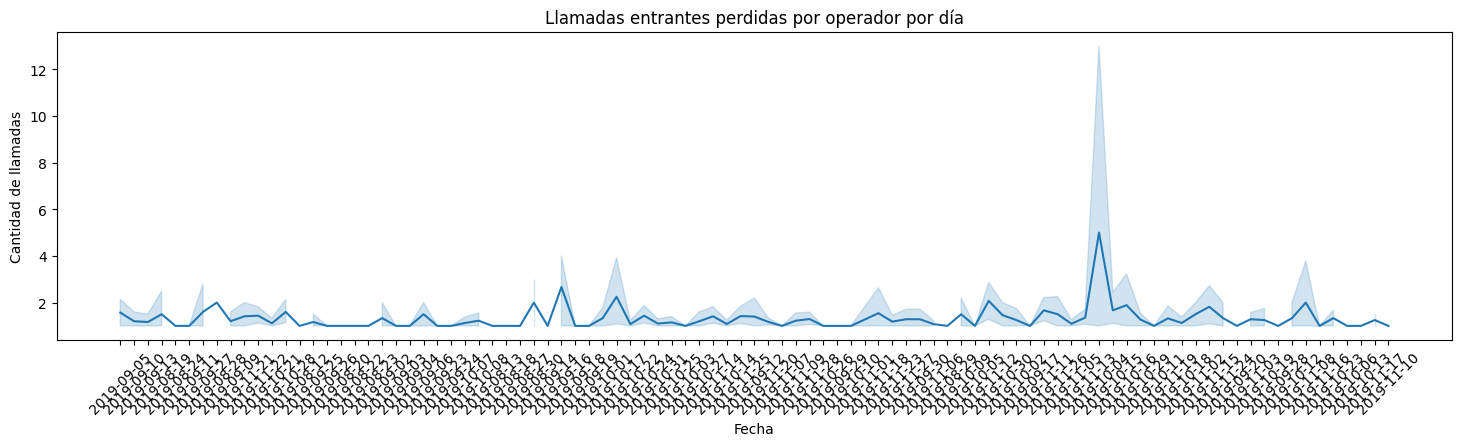

In [26]:
plt.figure(figsize=(18, 4))
sns.lineplot(data=df_in_missed_operator_day, x='ymd', y='calls_count')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.xticks(rotation=45)
plt.show()

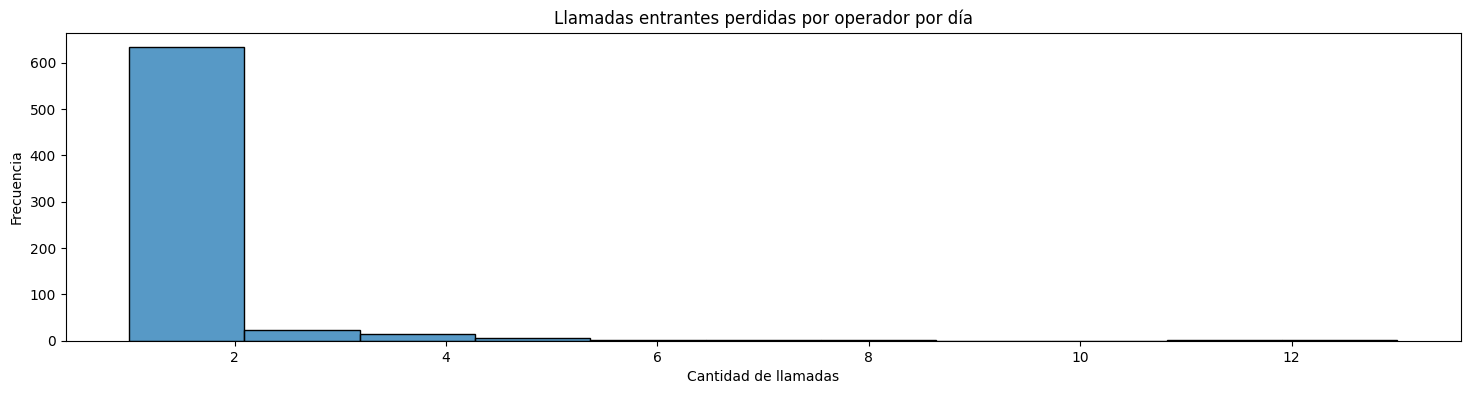

In [27]:
plt.figure(figsize=(18, 4))
sns.histplot(data=df_in_missed_operator_day, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

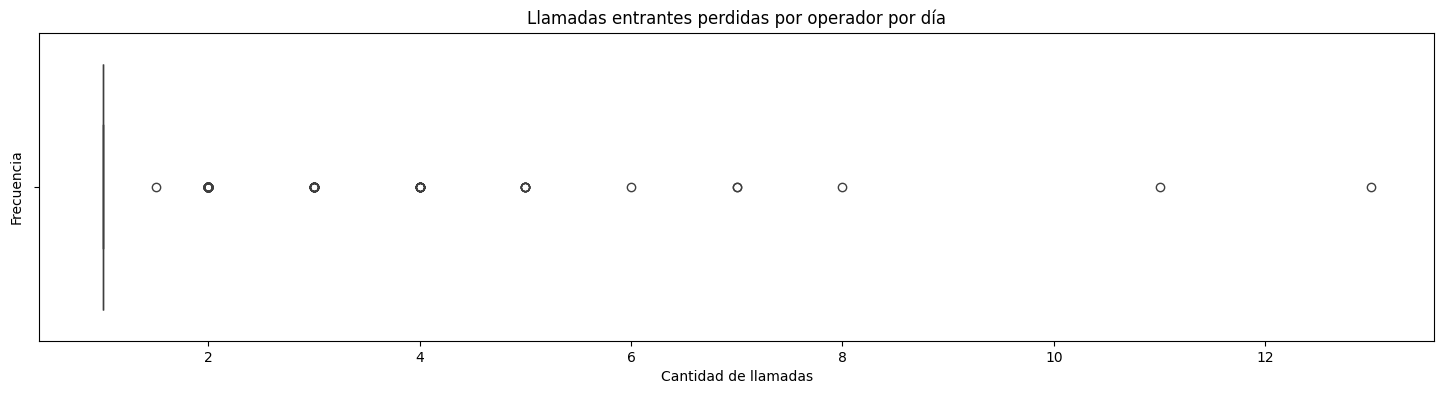

In [28]:
plt.figure(figsize=(18, 4))
sns.boxplot(data=df_in_missed_operator_day, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador por día')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos:
* Debido a la naturaleza del proceso, puede esperarse cierto nivel de llamadas perdidas
* Se observa un promedio de 1.35 llamadas perdidas por operador por día, con una mediana de 1.0
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Llamadas entrantes perdidas totales

In [29]:
df_in_missed = dfo[dfo['direction']=='in']
df_in_missed = df_in_missed[df_in_missed['is_missed_call']]
df_in_missed_operator = df_in_missed.groupby(['operator_id']).agg({'calls_count': 'sum'}).reset_index()
print('Descripción de la serie')
print(df_in_missed_operator['calls_count'].describe())
df_in_missed_operator.sample(2)

Descripción de la serie
count    239.000000
mean       3.874477
std        5.943089
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       52.000000
Name: calls_count, dtype: float64


,operator_id,calls_count
178,937902.0,1
4,884408.0,4


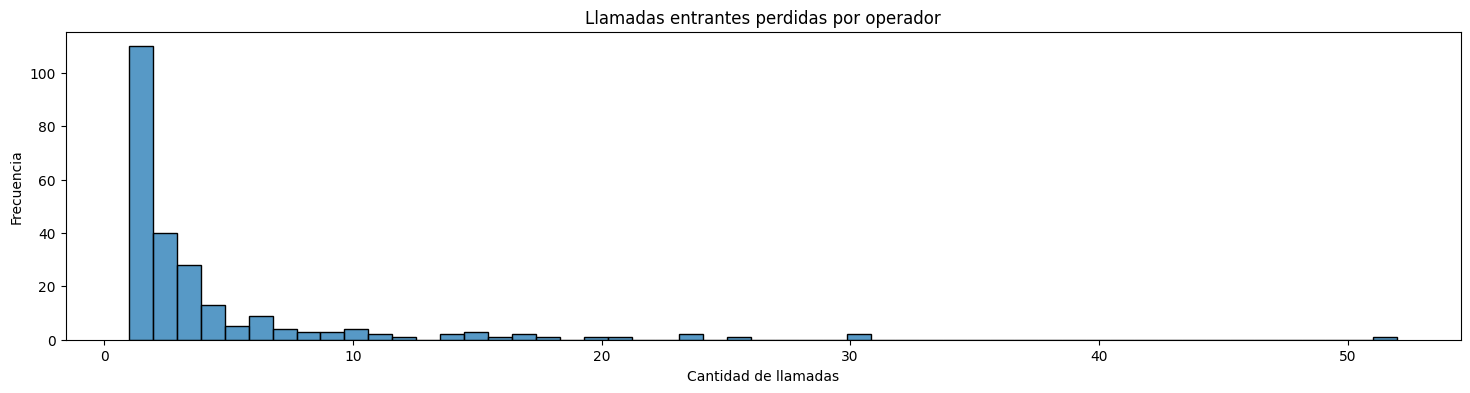

In [30]:
plt.figure(figsize=(18, 4))
sns.histplot(data=df_in_missed_operator, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

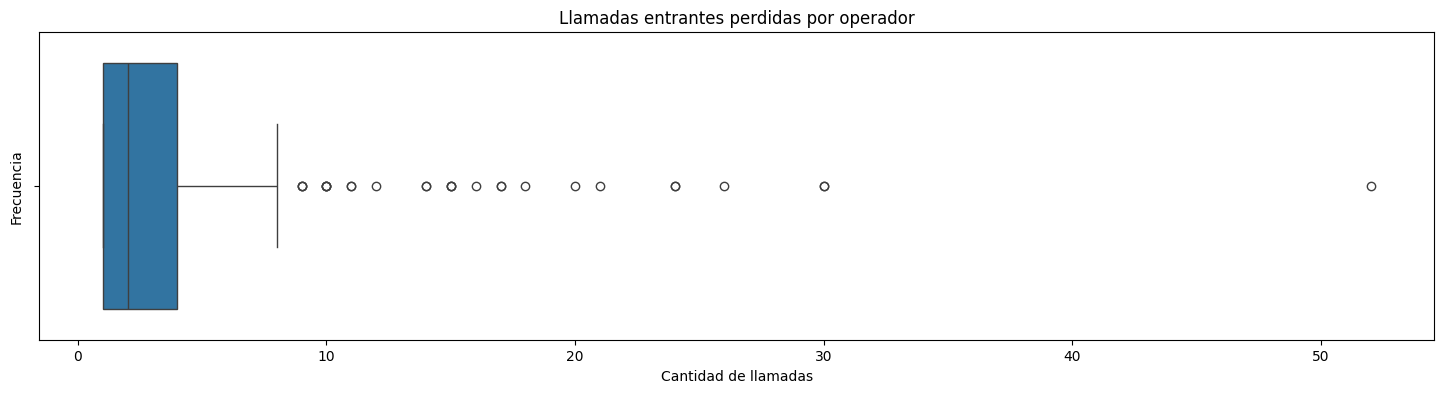

In [31]:
plt.figure(figsize=(18, 4))
sns.boxplot(data=df_in_missed_operator, x='calls_count')

plt.title('Llamadas entrantes perdidas por operador')
plt.xlabel('Cantidad de llamadas')
plt.ylabel('Frecuencia')
plt.show()

Hallazgos:
* Debido a la naturaleza del proceso, puede esperarse cierto nivel de llamadas perdidas TOTALES
* Se observa un promedio de 3.87 llamadas perdidas por operador por día, con una mediana de 2.0
* La media resulta mayor a la mediana y se observa un sesgo a la derecha pues hay valores extremadamente altos que "estiran" la media hacia arriba

### Operadores con mayores ineficiencias

In [32]:
df_in_missed_operator_list = df_in_missed_operator.sort_values(by='calls_count', ascending=False)

df_in_missed_operator_list.head(10)

,operator_id,calls_count
98,913942.0,52
196,940588.0,30
210,944226.0,30
6,885890.0,26
206,944216.0,24
179,937956.0,24
222,951508.0,21
5,885876.0,20
208,944220.0,18
209,944222.0,17


In [33]:
df_in_missed_operator_evolution = df_in_missed.pivot_table(index='operator_id', 
                                                           columns='month', 
                                                           values='calls_count', 
                                                           aggfunc='sum',
                                                           margins=True, margins_name='Total'
                                                           ).reset_index()

df_in_missed_operator_evolution = df_in_missed_operator_evolution.fillna(0)
df_in_missed_operator_evolution = df_in_missed_operator_evolution.sort_values(by='Total', ascending=False)

df_in_missed_operator_evolution = df_in_missed_operator_evolution[df_in_missed_operator_evolution['operator_id'] != 'Total']
df_in_missed_operator_evolution = df_in_missed_operator_evolution.head(10)


In [34]:
df_in_missed_operator_evolution.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 98 to 201
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  10 non-null     object 
 1   8            10 non-null     float64
 2   9            10 non-null     float64
 3   10           10 non-null     float64
 4   11           10 non-null     float64
 5   Total        10 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 560.0+ bytes


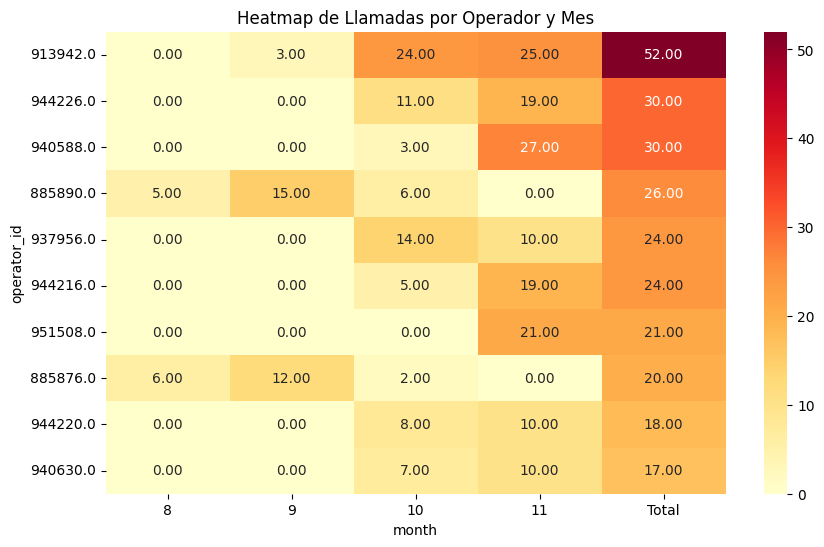

In [35]:
# Establecer 'operator_id' como índice
df_in_missed_operator_evolution.set_index('operator_id', inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(df_in_missed_operator_evolution, cmap='YlOrRd', annot=True, fmt='.2f', cbar=True)
plt.title('Heatmap de Llamadas por Operador y Mes')
plt.show()

Hallazgos:
* Identificar a los operadores con ineficiencias es importante para poder entrenarlos y ofrecerles la oportunidad de mejorar su calidad de trabajo
* Se debe también conocer la evolución de la performance del trabajador, lo cual resulta muy visible con el mapa de calor


## Ineficiencias en LLAMADAS SALIENTES

## Ineficiencias en TIEMPO DE ESPERA

# Conclusiones y Recomendaciones
================================================================================================================================